# 17장 세상에 없는 얼굴 GAN, 오토인코더

## 3. 적대적 신경망(GAN) 실행하기

https://this-person-does-not-exist.com/ 에 가면 ai가 만든 새상에 없는 사람이미지를 볼 수 있다. 딥러닝이 가상으로 만든 이미지이다.

특징을 모아 놓았다면 그 특징만을 이용하는 방법이다. <br />
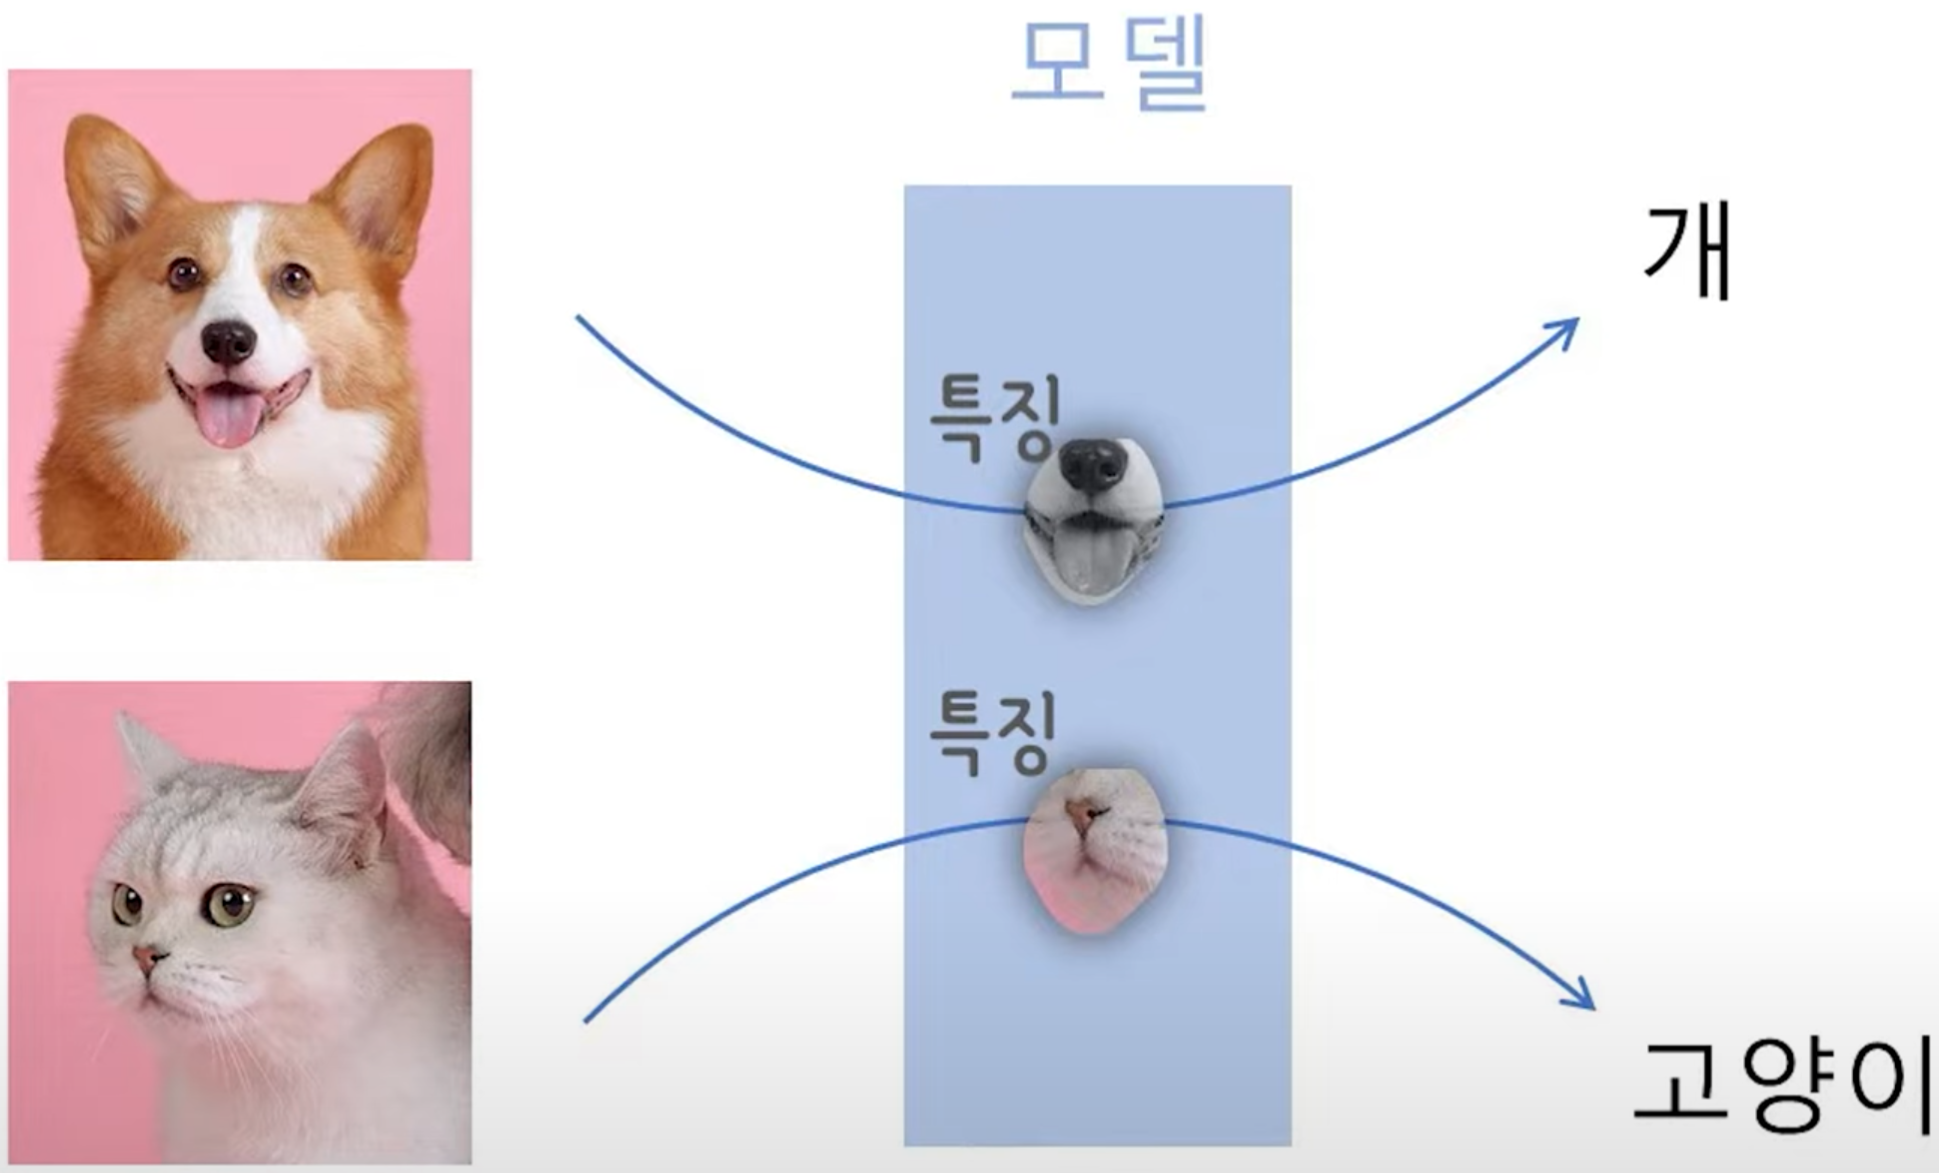<br />
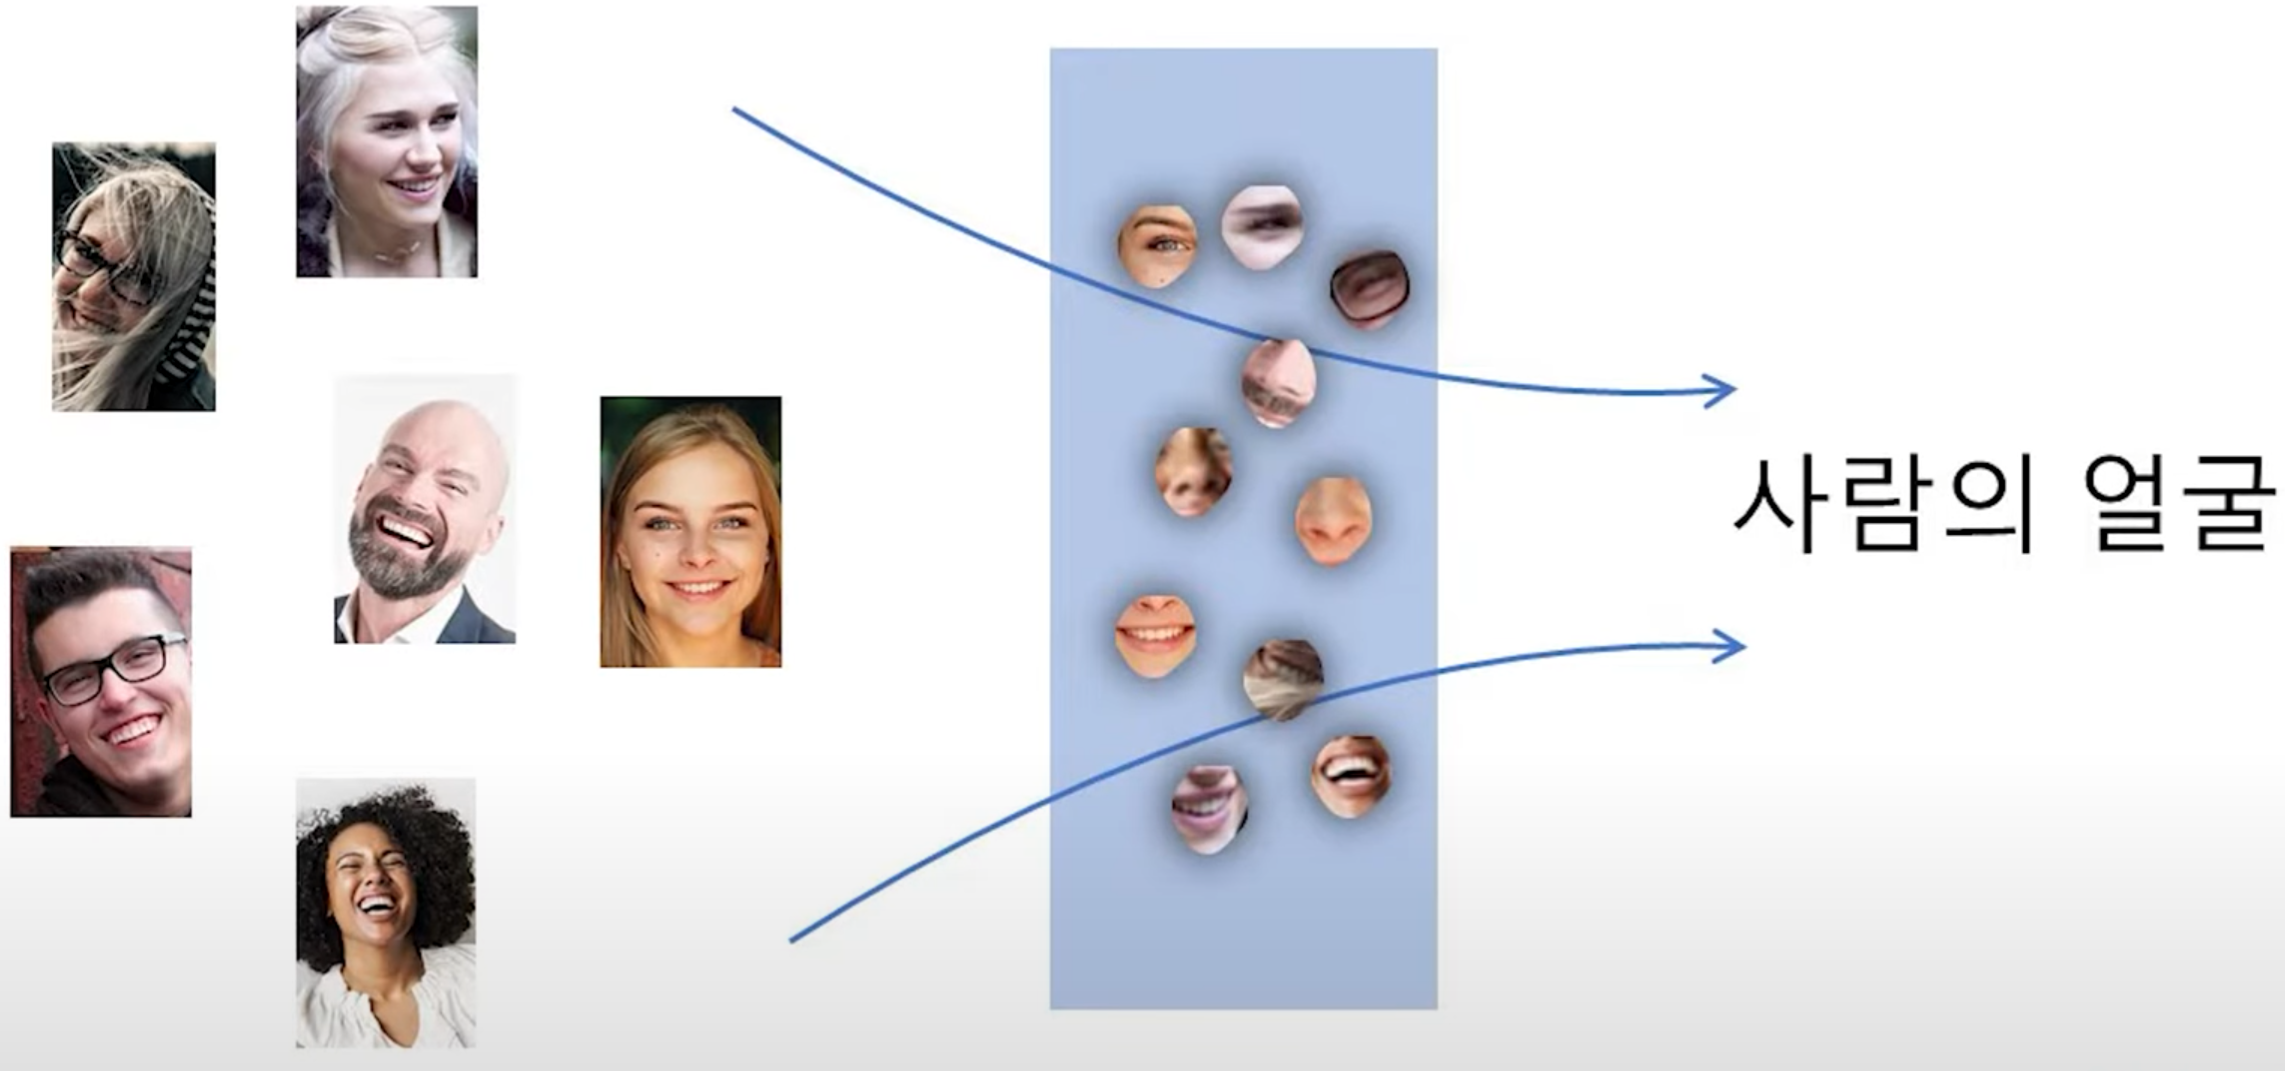<br />
이렇게 특징들을 모아둔다면 그 특징에 해당하는 것을 재현할 수 있을 것이다.<br />
위 사이트는 이러한 특징들을 모아 원하는 것을 재현하게 만든것이다.<br />
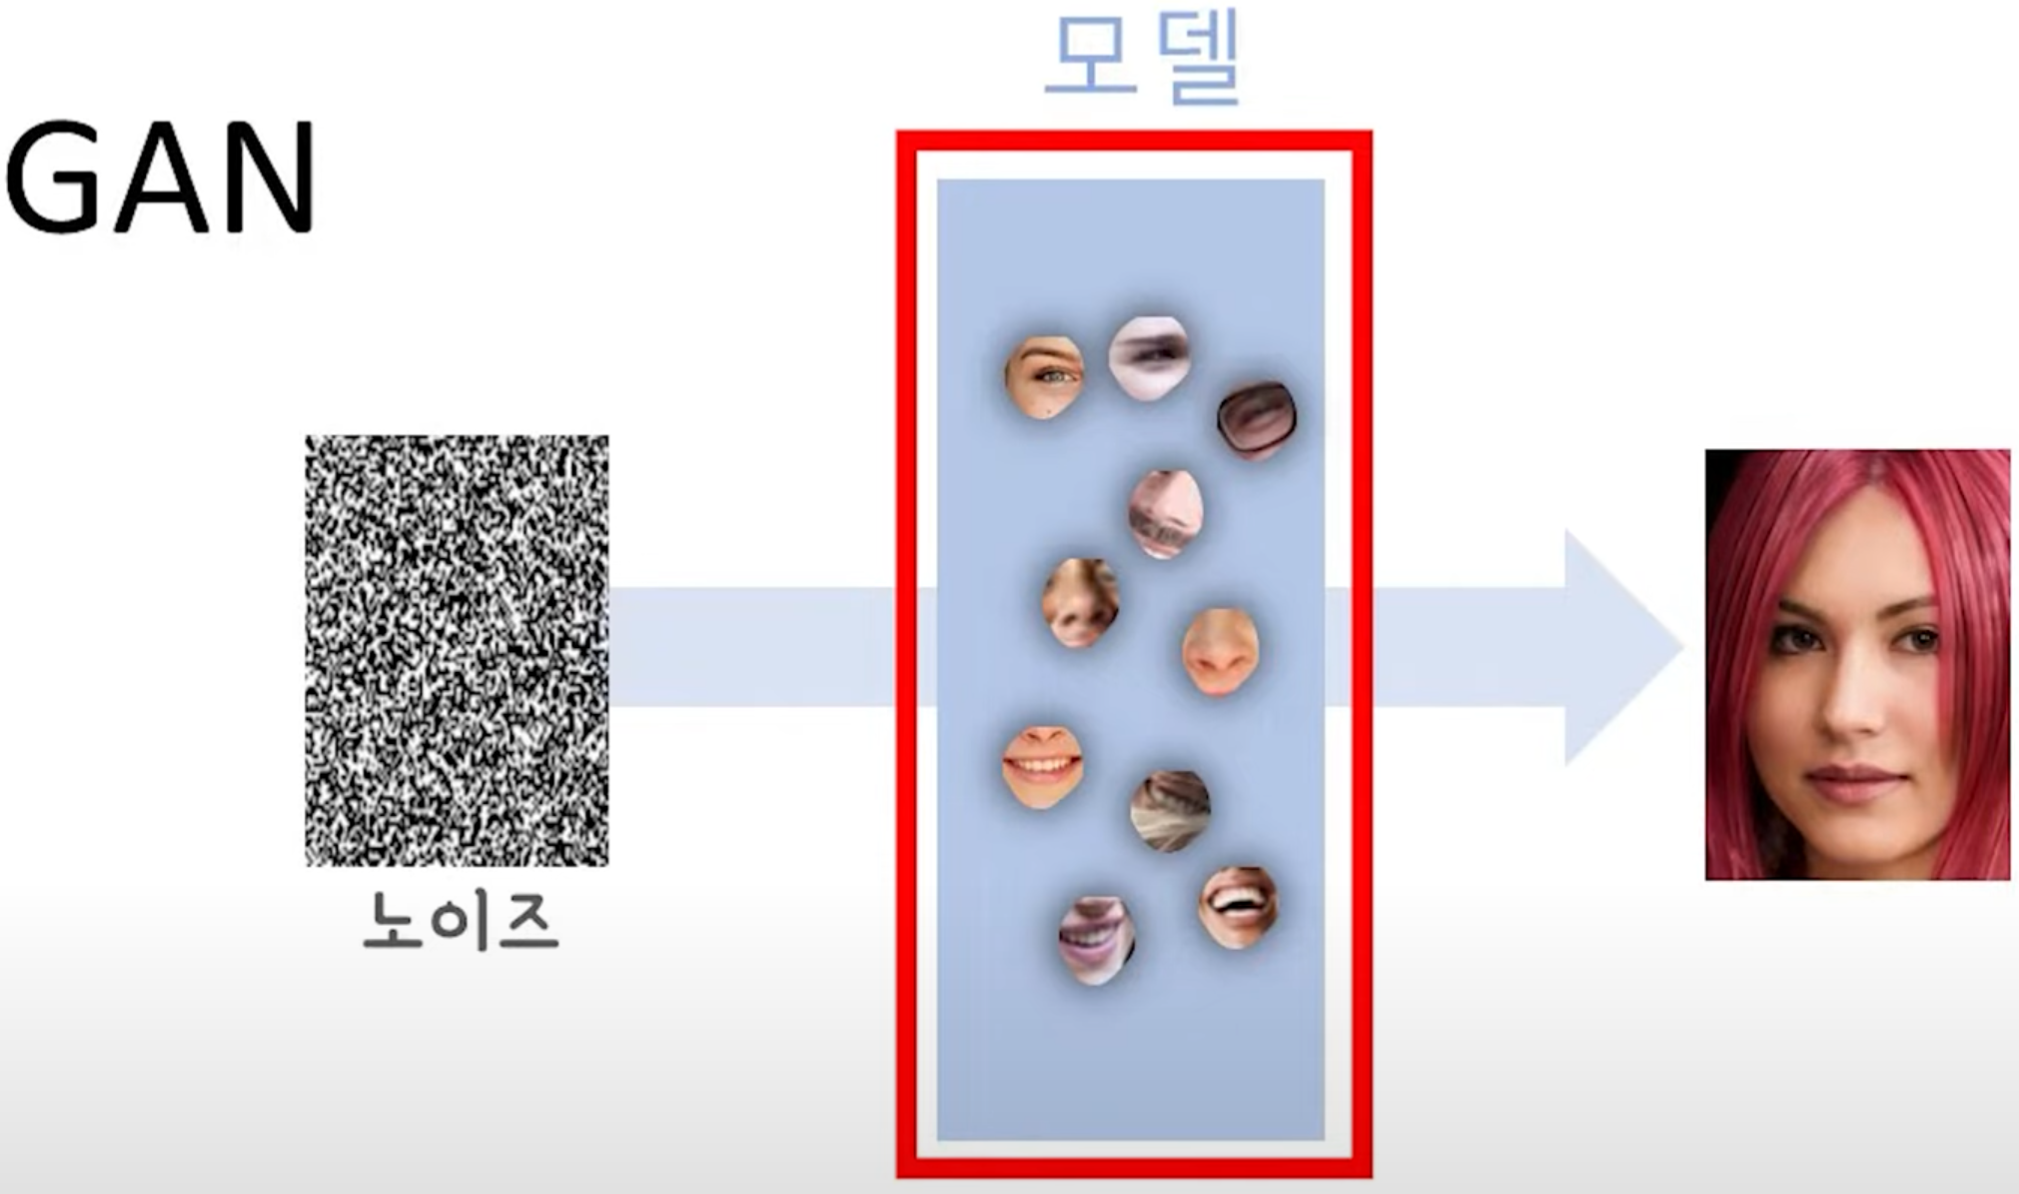<br />
노이즈 상태 였던 것이 특장을 만나게 되면 그 특장에 맞는 모습을 그려낸다는 것이다.

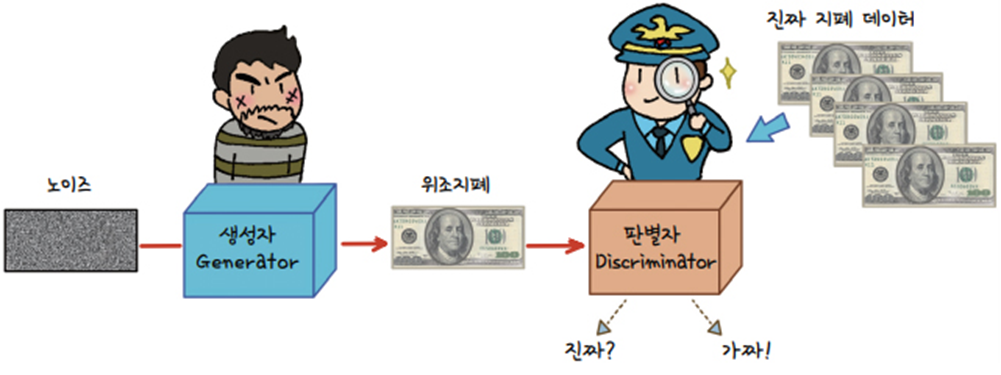

위 그림은 gan알고리즘에 대한 설명이다.<br /> 위조지폐를 예로 들어 설명했다.<br />
위조 지폐를 판별한다는 것은 아무것도 없는 상태애서 위조지폐를 만드는 곳이 있고 위조 지폐가 진짜와 같은지를 판별하는 곳, 이렇게 두개가 있아야 할 것이다.<br /> 
gan이라는 것은 노이즈데이터를 가지고 위조지폐를 만든(생성자) 후 판별자가 진짜와 같은지를 분별을 한 후 진짜와 같지 않으면 다시 생성자에게 보내어 진짜 지폐와 같은 결과가 나올때까지 계속한다.
노이즈 데이터를 이용해서 진짜 얼굴과 같은지 아닌지를 판별을 해서 진짜 얼굴과 같을 때가지 반복하게 한다.
gan만으로는 원하는 이미지를 생성하지 못할 경우가 많아  발전된 알고리즘으로 dcGan이라는 것이 고안되었다.

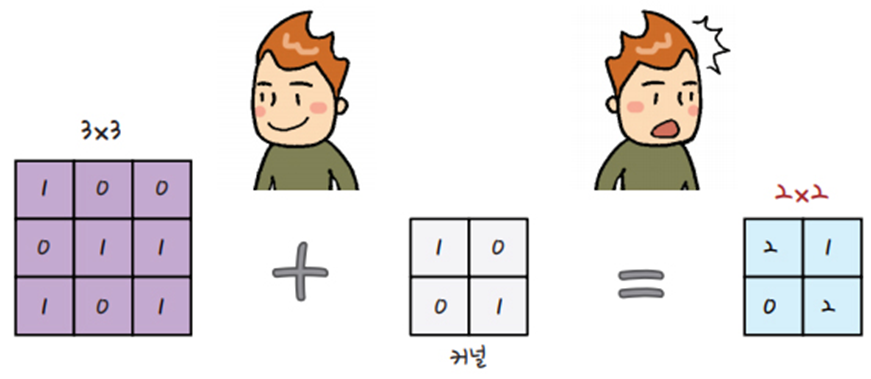

폴링은 이미지에 커널을 사용하게 되면 작은 이미지가 만들어지는 것을 알 수 있었다. 이것이 컨폴루션의 기본 개념이다<br />
이렇게 컨볼루션을 사용하게 되면 처음의 input이미지 보다 작은 output이미지가 만들어질 것이다.<br />
그런데 input 이미지와 output이미지가 같게 만들어져야 한다. 그래서 처음 사이즈와 마지막에 만들어지는 사이즈가 같아야 하는데 그 때 사용하는 기법을 패딩이라고 한다.

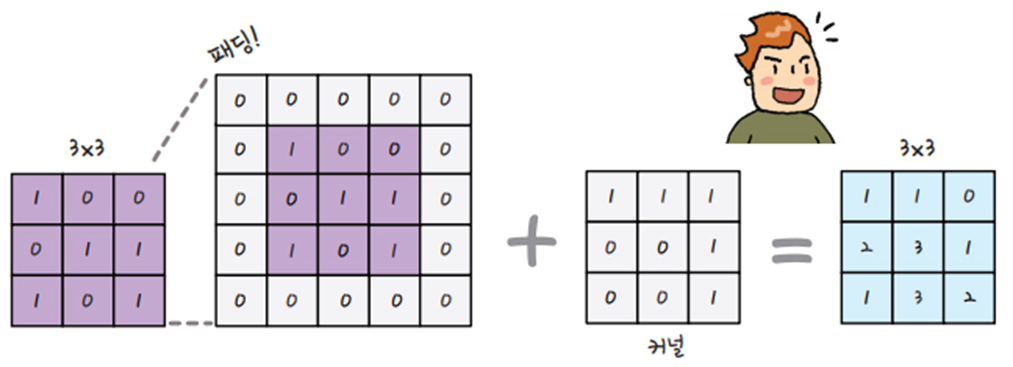

In [ ]:
들어온데이터(원 데이터)에 0으로 감싸게 되고 다시 커널을 사용하면 결과는 같은 크기가 되는 것을 알 수 있다.<br />
맵의 크기를 유지하기 위해서 사용하는 기법이 패딩이다.

### 실습: GAN 모델 만들기

In [ ]:
from tensorflow.keras.datasets import mnist # 손글씨의 크기는 28* 28이다.
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, LeakyReLU, UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

import numpy as np
import matplotlib.pyplot as plt
import os
os.makedirs("./data/gan_images", exist_ok=True)
# 생성자(generator)와 판별자(discriminator) 두개를 만들어서 사용하고 있다.
# 생성자 모델을 만듭니다.
generator = Sequential() 
                                                                        # 28*28인 순글씨 에이터를 출력해야 하므로 최종 크기는 28*28이어야 한다.
                                                                        # 128*7*7은 로드의 수를 말하는 것이고 7*7은 손글씨 이미지 크기를 지정하기 위해서
generator.add(Dense(128*7*7, input_dim=100, activation=LeakyReLU(0.2))) # 128은 임의 값을 넣었다. 테스트 한 결과 128이 잘됨.(테스트 할 때 임의 값을 사용함).
                                                                        # 7*7이유는 2(UpSampling2D)배씩 늘어나면 나중에 28*28이 되기 때문이다.
                                                                        # LeakyReLU(0.2)는 relu와 같은데 relu는 0또는 1로만 바꾸는데 LeakyReLU(0.2)는 다른
                                                                        # 값으로도 바꿀 수 있는데 0.2는 음수일 때는 0.2로 사용해라는 의미

generator.add(BatchNormalization())                                     # BatchNormalization()
                                                                        # 배치정규화는 입력값에 편차가 많이지면 불안전한 모델이 만들어 지므로 
                                                                        #                     평균이 0, 분산이 1이 되도록 만들어준다.

generator.add(Reshape((7, 7, 128)))                                     # 128*7*7인 1차원 배열을 2차원으로 변경 Reshape((7, 7, 128)

generator.add(UpSampling2D())                                           # 7*7을 2배로 만들어준다. 14 * 14         
generator.add(Conv2D(64, kernel_size=5, padding='same'))               # padding='same'은 들어온 값가 나가는 값의 크기가 같아야 한다.          
                                                                        # kernel_size=5는 5*5 커널을 이용 64번의 컨볼루션을 만든다.
generator.add(BatchNormalization())                                     
                                                                        

generator.add(Activation(LeakyReLU(0.2)))                               
generator.add(UpSampling2D())                                  # 14 * 14를 두배로 만들어서 28 * 28로 만들어 mnist에 있는 손글씨 사이즈로 만들어주었다.
generator.add(Conv2D(1, kernel_size=5, padding='same', activation='tanh')) #tanh홀성화함수는 -1 ~ 1 사이의 값을 사용
                                                               # padding='same'은 커널을 지나도 크기가 동일하게 만들어져라.
# 노이즈 상태인 것을 generator를 거쳐서 이미지 생

# 판별자 모델을 만듭니다. # 기존의 이미지와 generator가 만든 이미지가 얼마나 정확한지 판별하기 위해. 여기서는 컨볼루션과정을 그대로 진행한다.
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=5, strides=2, input_shape=(28,28,1), padding="same"))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding="same"))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))     # 맞는지 틀린지만 판별하기 때문에 sigmoid
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5), metrics=['accuracy'])
                                                # 맞는지 틀린지를 판별하기 위해서 판별자 compile과정을 거치게 된다.
                                            
discriminator.trainable = False # 판별자는 판별만 하고 다시 generator에게 돌려줘야 한다
                                # 그러므로 판별자는 판별만 하는 것이지 학습을 해서는 안되기 때문에 False를 주었다.


# 아래 그램에 대한 코드이다.

# 생성자와 판별자 모델을 연결시키는 gan 모델을 만듭니다.
ginput = Input(shape=(100,)) # shape=(100,)은 랜덤하개 100개를 이용해서 만들어라.
dis_output = discriminator(generator(ginput)) # ginput을 이용해서 generator가 생성을 하고 discriminator가 판별을 하도록 한다.

gan = Model(ginput, dis_output) # ginput과 dis_output을 주어 ginput값과 dis_output의 차이가 없을 때까지 모델을 생성

# 같은지 다른지를 판별하기 위해서 binary_crossentropy인 손실함수를 사용했다.
gan.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))
gan.summary()

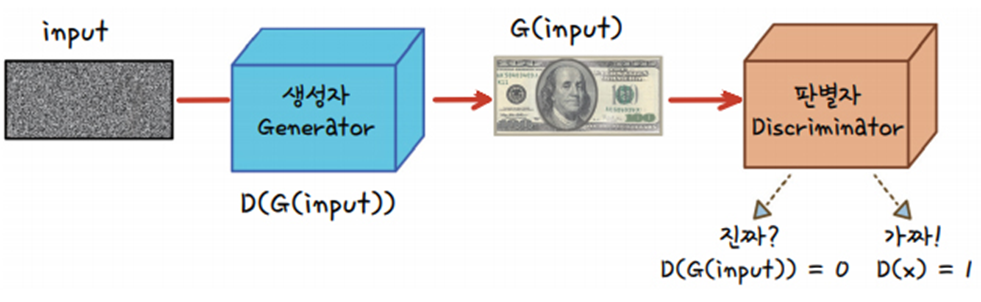<br />
생산자 만든 이미지를 판별자에게 주면 판별자가 판별(g(input))을 하고 가짜면 d에게 다시 d(g(imput))줘서 g(input)과 d(g(imput))이 비슷할 때까지 한다.

In [ ]:
# 신경망을 실행시키는 함수를 만듭니다.
def gan_train(epoch, batch_size, saving_interval):

  # MNIST 데이터를 불러옵니다.  # 판별자가 판별을 할 수 있게 이미지를 가져온다.
  (X_train, _), (_, _) = mnist.load_data()  # 테스트 과정은 필요 없고 이미지만 사용할 것이기 때문에 X_train만 불러왔습니다.
  X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
  X_train = (X_train - 127.5) / 127.5  # 픽셀 값은 0에서 255 사이의 값입니다. 이전에 255로 나누어 줄때는 이를 0~1 사이의 값으로 바꾸었던 것인데, 
                                       # 여기서는 127.5를 빼준 뒤 127.5로 나누어 줌으로 인해 -1에서 1사이의 값으로 바뀌게 됩니다.
                                      # tanh활성화 함수를 사용했기 때문에 127.5를 빼고 나눠줬다. -1 ~ 1사이의 값을 만들기 위해서
  # X_train.shape, Y_train.shape, X_test.shape, Y_test.shape 

  true = np.ones((batch_size, 1)) # 1로 채워져 있는 배열 : batch_size가 32라면 32행 1열짜리 2차원 원배열이다.
  fake = np.zeros((batch_size, 1)) # 0으로 채워져 있는 배열 : batch_size가 32라면 32행 1열짜리 2차원 재로배열이다.

  for i in range(epoch):
          #discriminator.trainable = True

          # 실제 데이터를 판별자에 입력하는 부분입니다.
          idx = np.random.randint(0, X_train.shape[0], batch_size) # X_train.shape[0]는 28 * 28인 60000개의 이미지
                                        # idx는 0부터 X_train.shape[0] - 1 (즉, 0 ~ 59999) 범위 내에서 랜덤하게 32개의 1차원 배열
                                        # 즉 60000개 중 랜덤하게 32개를 가져와라.
          imgs = X_train[idx] # 32 랜덤하게 불러온 32개의 이미지를 저장
          d_loss_real = discriminator.train_on_batch(imgs, true) # true는 imgs는 잔짜 이미지임을 나타내는 것이다. 이미지에 1인 label 지정
                                                                 # true = np.ones((batch_size, 1))를 적용

          # 가상 이미지를 판별자에 입력하는 부분입니다.
          noise = np.random.normal(0, 1, (batch_size, 100)) # 가짜 이미지 32개 # 평균이 0이고 표준편가 1인 100열인 2개의 노이즈 벡터생성 , normal=정규분포
                                                           
          gen_imgs = generator.predict(noise, verbose=0) # noise를 벋아서 생성자가 새로운 이미지를 생성한다. verbose=0은 아무것도 출력하지 말아라.
                                                         # batch_size를 32로 주면 noise이미지 32개를 생성한다.

                                                                     # 가상의 이미지가 fake임을 판별자에게 알려줌
          d_loss_fake = discriminator.train_on_batch(gen_imgs, fake) # fake는 gen_imgs는 가짜 이미지임을 나타내는 것이다. 이미지에 0인 label 지정
                                                                     # fake = np.zeros((batch_size, 1))
          
          # 판별자와 생성자의 오차를 계산합니다.
          d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) # 진짜 이미지와 가짜 이미지를 더하고 2로 나눈 값의 오차가 적을때 까지 반복하고 오차가 적어지면 학습을 멈춤
          #discriminator.trainable = False # 판별자는 학습하지 않게 하기 위해 False

          noise = np.random.normal(0, 1, (batch_size, 100))
          g_loss = gan.train_on_batch(noise, true) # 가찌 이미지를 진짜라고 속여서 학습하게 만든다. 내가 만든 가짜 이미지를 구분자가 진짜라고 믿게 만들어야 해
                                                    # 가짜를 진짜라고 속여야 진짜에 가까운 이미지를 생성할 수 있다.

        # 이미지 출력
          if i % 100 == 0:
            print('epoch:%d' % i, ' d_loss:%.4f' % d_loss[0], ' g_loss:%.4f' % g_loss)
                                              #판별자의 손실값            생성자의 손실값
        # 이 부분은 중간 과정을 이미지로 저장해 주는 부분입니다. 이 장의 주요 내용과 관련이 없어
      
        # 소스 코드만 첨부합니다. 만들어진 이미지들은 gan_images 폴더에 저장됩니다.
          if i % saving_interval == 0: # 800번마다 결과가 저장되게 하였습니다.
            # noise 벡터를 사용하여 25개의 가짜 이미지를 생성
            noise = np.random.normal(0, 1, (25, 100))  # (25, 100) -> 25개의 100차원 잠재 벡터
            gen_imgs = generator.predict(noise, verbose=0)  # 생성된 25개의 이미지 (배치 크기: 25)
        
            # 생성된 이미지를 0-1 범위로 재조정 (이미지의 값이 -1~1로 나올 수 있으므로 0~1로 변환)
            gen_imgs = 0.5 * gen_imgs + 0.5
        
            # 5x5 격자에 이미지를 그리기 위해 subplot 생성
            fig, axs = plt.subplots(5, 5)  # 5x5 격자 -> 총 25개의 이미지 표시
            count = 0
            for j in range(5):
                for k in range(5):
                    axs[j, k].imshow(gen_imgs[count, :, :, 0], cmap='gray')  # 각 이미지 표시
                    axs[j, k].axis('off')  # 축은 표시하지 않음
                    count += 1
            
            # 생성된 이미지를 파일로 저장
            fig.savefig("./data/gan_images/gan_mnist_%d.png" % i)

gan_train(4001, 32, 800)  # 4000번 반복되고, 배치 사이즈는 32,  800번마다 결과가 저장되게 하였습니다.


## 4. 이미지의 특징을 추출하는 오토인코더

GAN이 세상에 존재하지 않는 완전한 가상의 것을 만들어 내는 반면에
- GAN으로 사람의 얼굴을 만들면 진짜 같아 보여도 실제로는 존재하지 않는 완전한 가상 이미지가 만들어짐
  
오토인코더는 입력 데이터의 특징을 효율적으로 담아낸 이미지를 만들어 냄
- 오토인코더로 사람의 얼굴을 만들 경우 초점이 좀 흐릿하고 윤곽이 불명확하지만 사람의 특징을 유추할 수 있는 것들이 모여 이미지가 만들어짐
- 주어진 데이터에 특징을 잘 포함하는 데이터를 만들 때 사용
- 부족한 학습 데이터 수를 효과적으로 늘려 주는 효과를 기대할 수 있음

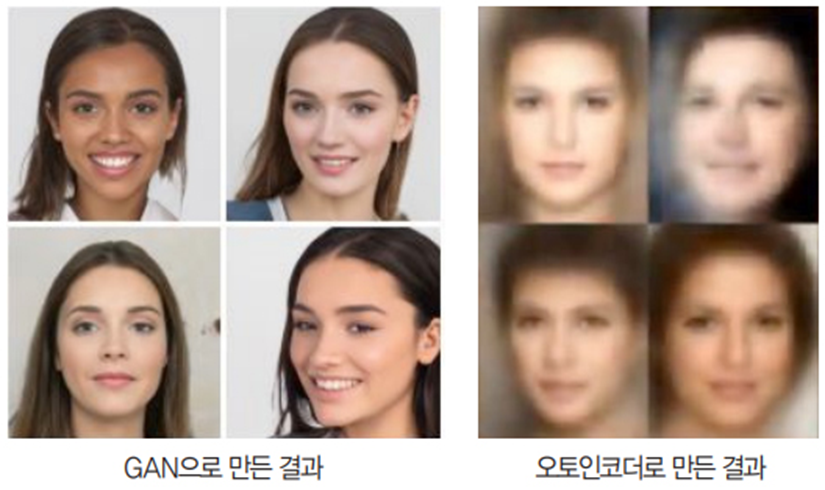

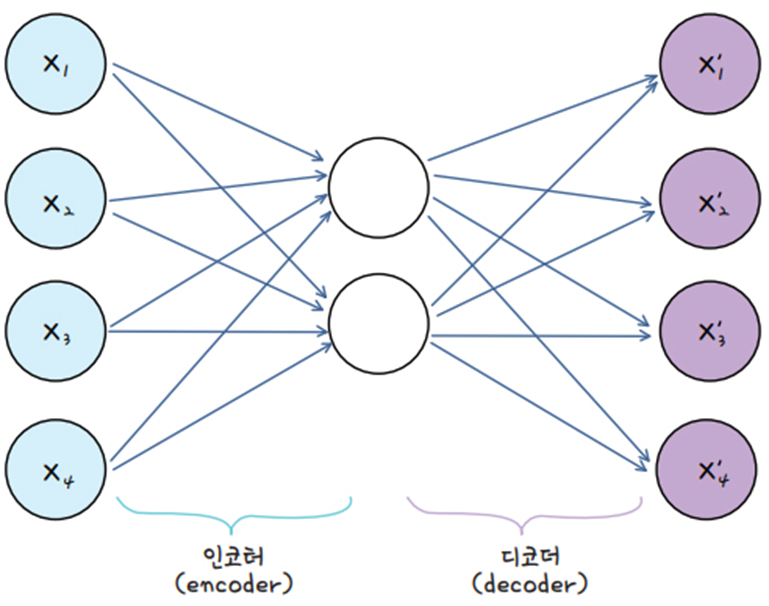

GAN하고 달리 실제 이미지와 비교하는 판별 부분이 빠져있고 <br />
대신 입력층보다 적은 수의 노드를 가진 은닉층을 중간에 넣어서 차원을 줄여 주는 과정이 있다.<br />
이때 소실된 데이터를 복원하기 위해 학습을 시작하고, 이 과정을 통해 입력 데이터의 특징을 효율적으로 응축한 새로운 출력이 나오는 원리<br />
입력 값 4개가 은닉층에서 2개로 줄었다가 출력층에서 다시 같은 크기로 만들어지면서 이렇게 줄였다 늘렸다 하면서 유사한데이터가 만드는 방법<br />
gan과 같인 인토더와 디코더가 있지만 다른점은 판별하는 작업을 하지 않는다.

### 실습: 오토인코더 실습하기

In [12]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape

import matplotlib.pyplot as plt
import numpy as np

# MNIST 데이터셋을 불러옵니다.

(X_train, _), (X_test, _) = mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32') / 255
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32') / 255

# 생성자 모델을 만듭니다.
autoencoder = Sequential()

# 인코딩 부분입니다.
autoencoder.add(Conv2D(16, kernel_size=3, padding='same', input_shape=(28,28,1), activation='relu'))
autoencoder.add(MaxPooling2D(pool_size=2, padding='same'))
autoencoder.add(Conv2D(8, kernel_size=3, activation='relu', padding='same'))
autoencoder.add(MaxPooling2D(pool_size=2, padding='same'))
autoencoder.add(Conv2D(8, kernel_size=3, strides=2, padding='same', activation='relu'))

# 디코딩 부분입니다.
autoencoder.add(Conv2D(8, kernel_size=3, padding='same', activation='relu'))
autoencoder.add(UpSampling2D())
autoencoder.add(Conv2D(8, kernel_size=3, padding='same', activation='relu'))
autoencoder.add(UpSampling2D())
autoencoder.add(Conv2D(16, kernel_size=3, activation='relu'))
autoencoder.add(UpSampling2D())
autoencoder.add(Conv2D(1, kernel_size=3, padding='same', activation='sigmoid'))

# 전체 구조를 확인합니다.
autoencoder.summary()
## summary를 보면 입력된 크기가 점점 추었다가 디코더 부분에서 점점 같은 크기가 되는 것을 알 수 있다. 

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_44 (Conv2D)                   │ (None, 28, 28, 16)          │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_45 (Conv2D)                   │ (None, 14, 14, 8)           │           1,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 7, 7, 8)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_46 (Conv2D)                   │ (None, 4, 4, 8)             │             584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_47 (Conv2D)                   │ (None, 4, 4, 8)             │             584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_22 (UpSampling2D)      │ (None, 8, 8, 8)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_48 (Conv2D)                   │ (None, 8, 8, 8)             │             584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_23 (UpSampling2D)      │ (None, 16, 16, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_49 (Conv2D)                   │ (None, 14, 14, 16)          │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_24 (UpSampling2D)      │ (None, 28, 28, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_50 (Conv2D)                   │ (None, 28, 28, 1)           │             145 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,385 (17.13 KB)

 Trainable params: 4,385 (17.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - loss: 0.2994 - val_loss: 0.1348
Epoch 2/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.1291 - val_loss: 0.1147
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1140 - val_loss: 0.1081
Epoch 4/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1082 - val_loss: 0.1040
Epoch 5/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1044 - val_loss: 0.1013
Epoch 6/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1020 - val_loss: 0.0988
Epoch 7/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0998 - val_loss: 0.0970
Epoch 8/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0979 - val_loss: 0.0959
Epoch 9/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0965 - val_loss: 0.0944
Epoch 10/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0952 - val_loss: 0.0934
Epoch 11/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0943 - val_loss: 0.0923
Epoch 12/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/st

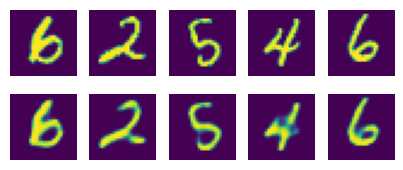

In [13]:
# 컴파일 및 학습을 하는 부분입니다.
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(X_train, X_train, epochs=50, batch_size=128, validation_data=(X_test, X_test))

# 학습된 결과를 출력하는 부분입니다.
random_test = np.random.randint(X_test.shape[0], size=5)  # 테스트할 이미지를 랜덤하게 불러옵니다.
ae_imgs = autoencoder.predict(X_test)                     # 앞서 만든 오토인코더 모델에 집어 넣습니다.

plt.figure(figsize=(7, 2))                         # 출력될 이미지의 크기를 정합니다.

for i, image_idx in enumerate(random_test):        # 랜덤하게 뽑은 이미지를 차례로 나열합니다.
   ax = plt.subplot(2, 7, i + 1)
   plt.imshow(X_test[image_idx].reshape(28, 28))   # 테스트할 이미지를 먼저 그대로 보여줍니다.
   ax.axis('off')
   ax = plt.subplot(2, 7, 7 + i +1)
   plt.imshow(ae_imgs[image_idx].reshape(28, 28))  # 오토인코딩 결과를 다음열에 출력합니다.
   ax.axis('off')
plt.show()

In [ ]:
오토 인코딩은 GAN과 달리 로이즈에서 진짜와 같은 새로운 이미지를 만드는 것이 아니라 실제 이미지에서 특징만 뽑은 이미지를 만들때 사용한다,

In [ ]:
# 사람 이미지 학습해서 가짜 이미지 만들기

In [ ]:
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, BatchNormalization, Activation, LeakyReLU, UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import os
import glob

# -------------------------------
# 1. 학습용 이미지 로드
# -------------------------------
img_rows, img_cols, channels = 64, 64, 3
img_folder = "person_images"  # 이미지가 들어있는 폴더
img_paths = glob.glob(f"{img_folder}/*.jpg")  # jpg 파일 불러오기

# 이미지 읽어서 numpy 배열로 변환
X_train = np.array([image.img_to_array(image.load_img(p, target_size=(img_rows, img_cols))) for p in img_paths])
X_train = (X_train / 127.5) - 1  # -1 ~ 1 범위로 정규화

# -------------------------------
# 2. Generator 모델 정의
# -------------------------------
generator = Sequential()
generator.add(Dense(256*8*8, input_dim=100, activation=LeakyReLU(0.2)))
generator.add(BatchNormalization())
generator.add(Reshape((8, 8, 256)))
generator.add(UpSampling2D())
generator.add(Conv2D(128, kernel_size=5, padding='same'))
generator.add(BatchNormalization())
generator.add(Activation(LeakyReLU(0.2)))
generator.add(UpSampling2D())
generator.add(Conv2D(64, kernel_size=5, padding='same'))
generator.add(BatchNormalization())
generator.add(Activation(LeakyReLU(0.2)))
generator.add(UpSampling2D())
generator.add(Conv2D(channels, kernel_size=5, padding='same', activation='tanh'))  # RGB

# -------------------------------
# 3. Discriminator 모델 정의
# -------------------------------
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=5, strides=2, input_shape=(img_rows,img_cols,channels), padding='same'))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding='same'))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy',
                      optimizer=Adam(learning_rate=0.0002, beta_1=0.5),
                      metrics=['accuracy'])

# -------------------------------
# 4. GAN 모델 정의
# -------------------------------
discriminator.trainable = False
g_input = Input(shape=(100,))
g_output = discriminator(generator(g_input))
gan = Model(g_input, g_output)
gan.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))

# -------------------------------
# 5. GAN 학습 함수
# -------------------------------
def gan_train(epochs=1000, batch_size=32):
    true = np.ones((batch_size,1))
    fake = np.zeros((batch_size,1))

    for epoch in range(1, epochs+1):
        # 1. Discriminator 학습
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_imgs = X_train[idx]

        discriminator.trainable = True
        d_loss_real = discriminator.train_on_batch(real_imgs, true)

        noise = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(noise)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # 2. Generator 학습
        discriminator.trainable = False
        noise = np.random.normal(0, 1, (batch_size, 100))
        g_loss = gan.train_on_batch(noise, true)

        if epoch % 100 == 0:
            print(f"{epoch} [D loss: {d_loss[0]:.4f}, acc.: {100*d_loss[1]:.2f}%] [G loss: {g_loss:.4f}]")

    # -------------------------------
    # 3. 학습 후 Generator로 이미지 1개 생성 및 출력
    # -------------------------------
    noise = np.random.normal(0, 1, (1,100))
    gen_img = generator.predict(noise)
    gen_img = 0.5 * gen_img + 0.5  # -1~1 → 0~1

    plt.imshow(gen_img[0])
    plt.axis('off')
    plt.show()

# -------------------------------
# 6. 학습 실행
# -------------------------------
gan_train(epochs=1000, batch_size=32)

In [ ]:
# 모델 저당
generator.save("generator_model.h5")
discriminator.save("discriminator_model.h5")
print("Generator와 Discriminator 모델이 저장되었습니다.")

In [ ]:
# 추가 학습하기
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
import numpy as np
import glob
import matplotlib.pyplot as plt

# -------------------------------
# 1. 저장된 모델 불러오기
# -------------------------------
loaded_generator = load_model("generator_model.h5", compile=False)
loaded_discriminator = load_model("discriminator_model.h5", compile=False)
print("Generator와 Discriminator 모델이 불러와졌습니다.")

# Discriminator 재컴파일
loaded_discriminator.compile(loss='binary_crossentropy',
                             optimizer=Adam(learning_rate=0.0002, beta_1=0.5),
                             metrics=['accuracy'])

# -------------------------------
# 2. GAN 모델 재정의 (Generator + Discriminator)
# -------------------------------
loaded_discriminator.trainable = False
g_input = Input(shape=(100,))
g_output = loaded_discriminator(loaded_generator(g_input))
gan = Model(g_input, g_output)
gan.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))

# -------------------------------
# 3. 추가 학습용 이미지 불러오기
# -------------------------------
img_rows, img_cols, channels = 64, 64, 3

# 학습할 이미지 폴더 (기존 + 새 이미지)
img_folder = "person_images_all"  # 기존 + 새로운 이미지 모두 넣은 폴더
img_paths = glob.glob(f"{img_folder}/*.jpg")

# 이미지 불러오기 함수
def load_images(paths):
    return np.array([image.img_to_array(image.load_img(p, target_size=(img_rows, img_cols))) for p in paths])

X_train = load_images(img_paths)
X_train = (X_train / 127.5) - 1  # -1~1 범위 정규화

# -------------------------------
# 4. 추가 학습 함수 정의
# -------------------------------
def gan_continue_train(X_train, epochs=500, batch_size=32):
    true = np.ones((batch_size,1))
    fake = np.zeros((batch_size,1))

    for epoch in range(1, epochs+1):
        # Discriminator 학습
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_imgs = X_train[idx]

        loaded_discriminator.trainable = True
        d_loss_real = loaded_discriminator.train_on_batch(real_imgs, true)

        noise = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = loaded_generator.predict(noise)
        d_loss_fake = loaded_discriminator.train_on_batch(gen_imgs, fake)

        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Generator 학습
        loaded_discriminator.trainable = False
        noise = np.random.normal(0, 1, (batch_size, 100))
        g_loss = gan.train_on_batch(noise, true)

        if epoch % 50 == 0:
            print(f"{epoch} [D loss: {d_loss[0]:.4f}, acc.: {100*d_loss[1]:.2f}%] [G loss: {g_loss:.4f}]")
            
            # 중간 이미지 생성
            noise_sample = np.random.normal(0, 1, (1,100))
            gen_img = loaded_generator.predict(noise_sample)
            gen_img = 0.5 * gen_img + 0.5
            plt.imshow(gen_img[0])
            plt.axis('off')
            plt.show()

    # 학습 후 모델 다시 저장
    # gan 모델 내부에 있는 Generator 레이어를 가져와서 저장
    updated_generator = gan.layers[1] 
    updated_generator.save("generator_model.h5")
    
    # Discriminator는 직접 학습되었으므로 loaded_discriminator 객체를 저장해도 무방
    loaded_discriminator.save("discriminator_model.h5") 
    print("추가 학습 완료 후 Generator와 Discriminator 모델이 저장되었습니다.")

# -------------------------------
# 5. 추가 학습 실행
# -------------------------------
gan_continue_train(X_train, epochs=500, batch_size=32)


In [ ]:
# 가상이미지 만들기
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# 1. 저장된 Generator 모델 불러오기
# -------------------------------
generator = load_model("generator_model.h5", compile=False)
print("Generator 모델이 불러와졌습니다.")

# -------------------------------
# 2. 가상 이미지 생성
# -------------------------------
# 랜덤 노이즈 입력
noise = np.random.normal(0, 1, (1, 100))  # 1개의 이미지 생성
gen_img = generator.predict(noise)

# -1~1 → 0~1 범위로 변환
gen_img = 0.5 * gen_img + 0.5

# -------------------------------
# 3. 이미지 시각화
# -------------------------------
plt.imshow(gen_img[0])
plt.axis('off')
plt.show()

# 반도체 데이터에 커볼류션과 autoencoder를 이용해 결측치 를 대체하기

In [ ]:
import pandas as pd
import numpy as np
import os
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, UpSampling1D, Reshape, Flatten, Cropping1D # ⭐ Cropping1D 추가
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
# 경고 메시지를 숨기기 위해 임시로 설정
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

# --- 설정 및 데이터 로드 (이전과 동일) ---
DATA_PATH = "https://raw.githubusercontent.com/SoongMoo/data/refs/heads/main/secom.data"
LABEL_PATH = "https://raw.githubusercontent.com/SoongMoo/data/refs/heads/main/secom_labels.data"
INPUT_DIM = 590

# 데이터 로드
df = pd.read_csv(DATA_PATH, sep=" ", header=None)
labels = pd.read_csv(LABEL_PATH, sep=" ", header=None)[0]
labels = labels.replace(-1, 0)

X = df.iloc[:, :]
y = labels

## 1. 데이터 전처리 및 Conv1D 입력 형태 변환 (이전과 동일)
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
X_imputed_temp = imputer.fit_transform(X)
scaler = StandardScaler()
X_scaled_temp = scaler.fit_transform(X_imputed_temp)
X_conv_input = X_scaled_temp.reshape(-1, INPUT_DIM, 1)


## 2. 순수 Conv1D Autoencoder 정의, 학습 및 복원 (Cropping1D 적용)
# ----------------------------------------------------------------------

def create_pure_cae(input_dim):
    cae_model = Sequential(name="Pure_Conv1D_Autoencoder")

    # === 인코더 (Encoder) ===
    # (N, 590, 1)
    cae_model.add(Conv1D(16, kernel_size=3, padding='same', activation='relu', input_shape=(input_dim, 1)))
    cae_model.add(MaxPooling1D(pool_size=2, padding='same')) # (N, 295, 16)

    cae_model.add(Conv1D(8, kernel_size=3, activation='relu', padding='same'))
    cae_model.add(MaxPooling1D(pool_size=2, padding='same')) # (N, 148, 8)

    # Bottleneck:
    cae_model.add(Conv1D(4, kernel_size=3, padding='same', activation='relu', name='Bottleneck')) # (N, 148, 4)

    # === 디코더 (Decoder) ===
    cae_model.add(Conv1D(8, kernel_size=3, padding='same', activation='relu'))
    cae_model.add(UpSampling1D(size=2)) # (N, 296, 8)

    cae_model.add(Conv1D(16, kernel_size=3, padding='same', activation='relu'))
    cae_model.add(UpSampling1D(size=2)) # (N, 592, 16)

    # 최종 출력 채널 1로 변경
    cae_model.add(Conv1D(1, kernel_size=3, padding='same', activation='linear')) # (N, 592, 1)

    # ⭐ 오류 해결 핵심: 592 -> 590으로 자르기 (끝에서 2개 Steps 제거)
    # Cropping1D((0, 2))는 시퀀스 시작(0)은 자르지 않고, 끝(2)에서 2개의 Steps를 자릅니다.
    cae_model.add(Cropping1D((0, 2))) # ⭐ (N, 590, 1)

    return cae_model

cae_model_pure = create_pure_cae(INPUT_DIM)
cae_model_pure.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# 이제 오류 없이 summary가 출력될 것입니다.
cae_model_pure.summary()

print("\n--- 순수 Conv1D Autoencoder 학습 시작 ---")
cae_model_pure.fit(X_conv_input, X_conv_input, epochs=50, batch_size=64, shuffle=True, verbose=2)
print("--- 순수 Conv1D Autoencoder 학습 완료 ---")

# 오토인코더를 이용한 최종 데이터 복원/대체
X_cae_imputed_3d = cae_model_pure.predict(X_conv_input)

# 분류 모델을 위해 3차원 -> 2차원 (N, 590)으로 변환
X_cae_imputed = X_cae_imputed_3d.reshape(-1, INPUT_DIM)


## 3. 복원된 데이터로 분류 모델 학습 및 예측 (이전과 동일하게 진행)
# ----------------------------------------------------------------------

# 학습 및 검증 데이터 분리
X_train, X_val, y_train, y_val = train_test_split(
    X_cae_imputed, y, test_size=0.2, random_state=42, stratify=y
)

# 분류 모델 설정 및 학습 (Dense Net)
classifier_model = Sequential(name="Fault_Classifier")
classifier_model.add(Dense(12, input_dim=INPUT_DIM, activation='relu', name='Dense_1'))
classifier_model.add(Dense(8, activation='relu', name='Dense_2'))
classifier_model.add(Dense(1, activation='sigmoid', name='Dense_3'))
classifier_model.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy'])

# 콜백 설정
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=20, verbose=1)
model_name = "secom_pure_conv1d_best_classifier.keras"
model_dir = "./data/model"
os.makedirs(model_dir, exist_ok=True)
modelpath = os.path.join(model_dir, model_name)
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=1, save_best_only=True)

# 모델 학습
print("\n--- 분류 모델 학습 시작 (Pure Conv1D AE Imputation 적용) ---")
history = classifier_model.fit(
    X_train, y_train,
    epochs=500,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping_callback, checkpointer],
    verbose=2
)
print(f"--- 분류 모델 학습 완료. 최적 모델은 '{modelpath}'에 저장됨 ---")

# --- 새로운 데이터 예측 (최적 모델 로드) ---
best_model = load_model(modelpath)
sample_index = 15
data_raw = df.iloc[sample_index, :]

# 예측 시 Conv1D 전처리 파이프라인 적용
data_imputed_temp = imputer.transform(data_raw.to_numpy().reshape(1, -1))
data_scaled_temp = scaler.transform(data_imputed_temp)
data_conv_input = data_scaled_temp.reshape(1, INPUT_DIM, 1)

# 1. 순수 Conv1D AE를 이용해 데이터 복원/대체
new_data_cae_imputed_3d = cae_model_pure.predict(data_conv_input, verbose=0)
new_data_cae_imputed = new_data_cae_imputed_3d.reshape(1, INPUT_DIM)

# 2. 분류 모델로 예측 수행
prediction = best_model.predict(new_data_cae_imputed, verbose=0)

# 예측 결과 출력
print(f"\n원본 데이터 {sample_index}번째 샘플 예측 결과:")
print(f"예측 확률: {prediction[0][0]:.4f}")
print(f"예측 결과 (0: 정상, 1: 불량): {int(prediction[0][0] > 0.5)}")

## Dense Autoencoder를 이용해 결측치 대체

In [ ]:
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer 
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
import os

# --- 데이터 로드 ---

DATA_PATH = "https://raw.githubusercontent.com/SoongMoo/data/refs/heads/main/secom.data"
LABEL_PATH = "https://raw.githubusercontent.com/SoongMoo/data/refs/heads/main/secom_labels.data"

df = pd.read_csv(DATA_PATH, sep=" ", header=None)
labels = pd.read_csv(LABEL_PATH, sep=" ", header=None)[0]
labels = labels.replace(-1, 0)  # 정상=0, 불량=1

X = df.iloc[:,:]
y = labels
INPUT_DIM = 590

# --- ⭐ 1단계: 초기 결측치 대체 및 스케일링 (Autoencoder 입력 준비) ---

# 1. 초기 결측치 대체: 오토인코더 학습을 위해 임시로 평균값으로 대체
# SimpleImputer를 사용하여 NaN을 채웁니다. (Imputer를 저장하여 예측 시 재사용)
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
X_imputed_temp = imputer.fit_transform(X)

# 2. 스케일링: StandardScaler를 적용 (Scaler를 저장하여 예측 시 재사용)
scaler = StandardScaler()
X_scaled_temp = scaler.fit_transform(X_imputed_temp)


# --- ⭐ 2단계: 오토인코더(Autoencoder) 모델 정의 및 학습 ---

# 오토인코더 모델 정의 (590 -> 32 -> 590 구조)
# 목표: 입력된 590차원 데이터를 압축(인코딩)했다가 다시 590차원으로 복원(디코딩)
ae_model = Sequential(name="Autoencoder_Imputer")
# 인코더: 입력층 (590) -> 은닉층 (128) -> 잠재 공간 (32)
ae_model.add(Dense(128, activation='relu', input_shape=(INPUT_DIM,)))
ae_model.add(Dense(32, activation='relu', name='Bottleneck')) # 잠재 공간
# 디코더: 잠재 공간 (32) -> 은닉층 (128) -> 출력층 (590)
ae_model.add(Dense(128, activation='relu'))
ae_model.add(Dense(INPUT_DIM, activation='linear')) # 입력과 같은 값을 복원해야 하므로 linear

ae_model.compile(optimizer='adam', loss='mse') # 복원 오차(MSE)를 최소화하도록 학습

print("\n--- 오토인코더 학습 시작 (데이터 패턴 학습) ---")
# 임시 스케일링된 데이터로 오토인코더 학습
# 오토인코더는 y 레이블 없이, X_scaled_temp를 X_scaled_temp로 복원하도록 학습합니다.
ae_model.fit(X_scaled_temp, X_scaled_temp, 
             epochs=50, 
             batch_size=64, 
             shuffle=True, 
             verbose=0)
print("--- 오토인코더 학습 완료 ---")

# --- ⭐ 3단계: 오토인코더를 이용한 최종 데이터 복원/대체 ---

# 오토인코더가 복원한(refined/imputed) 결과를 최종 학습 데이터로 사용합니다.
X_ae_imputed = ae_model.predict(X_scaled_temp)
print(f"오토인코더를 통해 복원된 데이터셋 형태: {X_ae_imputed.shape}")

# 4. 학습 및 검증 데이터 분리
X_train, X_val, y_train, y_val = train_test_split(
    X_ae_imputed, y, test_size=0.2, random_state=42, stratify=y
)

# --- 분류 모델 설정 및 학습 (콜백 적용) ---

# 분류 모델 정의
model = Sequential(name="Fault_Classifier")
model.add(Dense(12, input_dim=INPUT_DIM, activation='relu', name='Dense_1'))
model.add(Dense(8, activation='relu', name='Dense_2'))
model.add(Dense(1, activation='sigmoid', name='Dense_3'))
model.summary()

# 모델 컴파일
model.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy']) 

# 콜백 설정
early_stopping_callback = EarlyStopping(
    monitor='val_loss', 
    patience=20,
    verbose=1
)

model_name = "secom_ae_best_classifier.keras" # 파일명 변경
model_dir = "./data/model"
os.makedirs(model_dir, exist_ok=True) # 디렉토리 생성
modelpath = os.path.join(model_dir, model_name)

checkpointer = ModelCheckpoint(
    filepath=modelpath, 
    monitor='val_loss', 
    verbose=1, 
    save_best_only=True
)

# 모델 학습 (오토인코더로 복원된 X_ae_imputed 사용)
print("\n--- 분류 모델 학습 시작 (Autoencoder Imputation 적용) ---")

history = model.fit(
    X_train, 
    y_train, 
    epochs=500, # EarlyStopping을 위해 충분히 큰 수 설정
    batch_size=32, 
    validation_data=(X_val, y_val), 
    callbacks=[early_stopping_callback, checkpointer], 
    verbose=2
)

print(f"--- 분류 모델 학습 완료. 최적 모델은 '{modelpath}'에 저장됨 ---")

# --- 새로운 데이터 예측 (최적 모델 로드) ---

# 최적 모델 로드
from tensorflow.keras.models import load_model
best_model = load_model(modelpath)

# 원본 데이터의 15번째 샘플을 가져옵니다.
data_raw = df.iloc[15, :]

# ⭐ 중요: 예측 시에도 동일한 전처리 파이프라인 적용
# 1. NaN 처리 (Imputer 재사용)
data_imputed_temp = imputer.transform(data_raw.to_numpy().reshape(1, -1))
# 2. 스케일링 (Scaler 재사용)
data_scaled_temp = scaler.transform(data_imputed_temp)
# 3. 오토인코더 복원 (AE 모델 재사용)
new_data_ae_imputed = ae_model.predict(data_scaled_temp)

# 예측 수행
prediction = best_model.predict(new_data_ae_imputed)

# 예측 결과 출력
print(f"\n원본 데이터 {15}번째 샘플 예측 결과:")
print(f"예측 확률: {prediction[0][0]:.4f}")
print(f"예측 결과 (0: 정상, 1: 불량): {int(prediction[0][0] > 0.5)}")